# Analyzing the apartment rental prices in Prague
{:.no_toc}

> This is a rendered version of a Jupyter notebook. The source notebook can be found [in my GitHub repository](https://github.com/barjin/ndbi023-project), along with the data used in this analysis.

In this data analysis, I tried to understand the apartment rental prices in Prague. The data was collected from the real estate website [Sreality.cz](https://www.sreality.cz/). The data from this source includes the monthly prices, the property sizes, geolocations, and other features. The goal of this analysis is to understand the factors that influence the rental prices of apartments in Prague.

## Contents
{:.no_toc}

1. This is a placeholder for table of contents
{:toc}

## Acquiring the data

This section describes how the data was collected and preprocessed.

### SReality.cz

[Sreality.cz](https://www.sreality.cz/) is a real estate website that lists properties for sale and rent in the Czech Republic. This is the main source of the real estate price data used for this analysis. While the data posted here is probably not legally binding (the prices might be different when the actual contract is signed), it is a good approximation of the real estate prices in the Czech Republic - the best it can be without access to the actual contracts.

More details about the data collection and preprocessing can be found in the [real estate data preprocessing notebook](./sreality_preprocessing.md).

### PID stops

One of the hypotheses I have is that the proximity to the public transportation stops might influence the rental prices. This could go both ways - maybe people are willing to pay more for the convenience of living near a public transportation stop, or maybe the noise and the traffic from the stops might decrease the rental prices. To test this hypothesis, I collected the geolocations of the public transportation stops in Prague. The data was collected from the [PID OpenData](https://pid.cz/en/opendata/) portal.

More details about the data collection and preprocessing can be found in the [traffic data preprocessing notebook](./traffic_preprocessing.md).

### Airbnb listings

Another hypothesis I have is that the rental prices might be influenced by the competition from the short-term rental market. To test this hypothesis, I collected the geolocations of the Airbnb listings in Prague. The data was collected using the [Airbnb Scraper](https://apify.com/tri_angle/airbnb-scraper) on [Apify](https://apify.com/).

More details about the data collection and preprocessing can be found in the [airbnb data preprocessing notebook](./airbnb_preprocessing.md).

### Schools, parks, highways?

I also wanted to collect the geolocations of the schools and other amenities in Prague. For this, I used the [OpenStreetMap](https://www.openstreetmap.org/) data. The data was collected using the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API).

More details about the data collection and preprocessing can be found in the [map data preprocessing notebook](./osm_preprocessing.md).

## First look at the data

We can start with a "sanity check" - let's plot the real estate prices from SReality.cz as a scatter plot onto a "map" of Prague.

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/sreality/index.csv')

plt.ioff()

df.plot(
    kind='scatter', 
    x='locality_gps_lon', 
    y='locality_gps_lat', 
    c="price_summary_czk" , 
    colormap='viridis', 
    s=3, 
    figsize=(15, 10), 
    title="Rental prices per month in Prague, Czech Republic",
    xlabel="Longitude",
    ylabel="Latitude",
).get_figure().savefig('img/sreality/01_rental_prices.png', bbox_inches='tight')

plt.close()

| ![Rental prices per month in Prague, Czech Republic](img/sreality/01_rental_prices.png) |
|:--:|
| *Plotting the rental prices per month with scatterplot on a "map" of Prague* |

> Note that using the geographical coordinates as cartesian coordinates does not map the distances correctly (because the Earth is not flat). However, for small distances (just like in our case here), the error is negligible.
>
> The figure might also be slightly distorted because of the `figsize` used - the aspect ratio is just approximated and might not represent the reality correctly.

Looking at the color scale in the chart above, it seems that some places cost more than 200k CZK a month. 

This is at least suspicious - let's explore that. By sorting the dataset by the price in descending order, we can find the ids of the listings and compose their URLs to the real estate websites to see what's going on.

In [105]:
df.sort_values(
    'price_summary_czk', 
    ascending=False
).head()['hash_id'].astype(int).map(
    lambda x: f'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/{x}'
).values

array(['https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2296964428',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2434610508',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/1757791564',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/3889546572',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/238974284'],
      dtype=object)

| ![]( 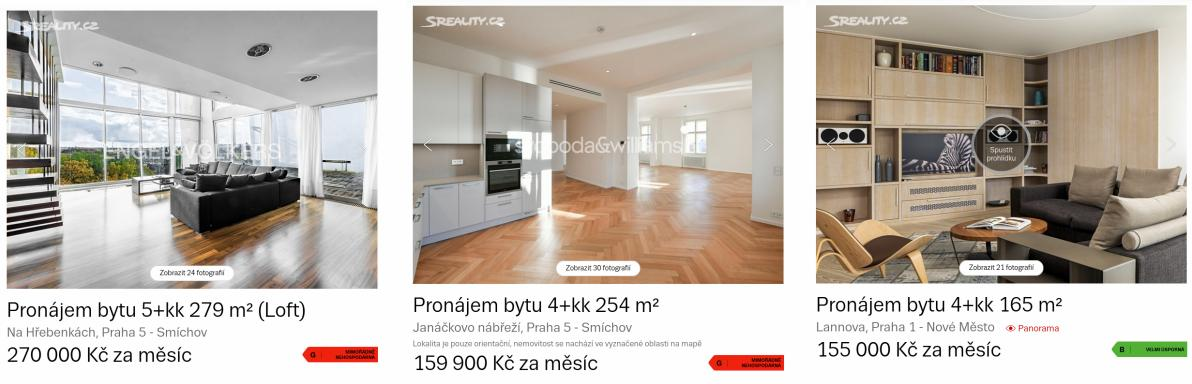) |
|:--:| 
| *Screenshots of the listings from the selection above* |

I stand corrected - these datapoints do not seem to be errorneous, there are just people with much more money than I would expect.

Other than that, the rental data seems (and least from the first glance) to be clean and ready for analysis.

## Location as the culprit?

Without joining the rentals data with any other datasets, we can just look at the location of the properties and see how well it correlates with the rental price.

By using the `staticmap` library, we can generate an actual map of the listings. Let's try to plot the listings on a map of Prague.
To get more variance in the data, we can only plot the listings with a price of 50000 CZK per month or less.

In [106]:
import utils.map_utils as mu

mu.get_map_scale(
    df[df['price_summary_czk'] <= 50000], 
    color_attribute='price_summary_czk', 
    scale_label='Price in CZK / mo', 
    title='Rental prices per month in Prague, Czech Republic'
).savefig(
    'img/sreality/02_rental_prices_map.png', 
    bbox_inches='tight'
)

| ![Map of filtered listing prices](./img/sreality/02_rental_prices_map.png) |
|:--:|
| *Map of filtered listings. Prices are color coded.* |

Unsurprisingly, the priciest listings are located in the areas of Prague 1 and Prague 2, which is the city center.

The total price of the listing might not be the best measure however, as we didn't account for the usable areas of the estate. We can try to plot the price per square meter instead.

In [107]:
df['price_per_sqm'] = df['price_summary_czk'] / df['usable_area']

In [108]:
mu.get_map_scale(
    df[df['price_per_sqm'] < 700], 
    color_attribute='price_per_sqm',
    title='Price per sqm in Prague, Czech Republic'
).savefig(
    'img/sreality/03_price_per_sqm_map.png', 
    bbox_inches='tight'
)

| ![Map of filtered listing prices per square meter](./img/sreality/03_price_per_sqm_map.png) |
|:--:|
| *Map of filtered listings per square meter. Prices are color coded.* |

It really seems that there are certain "high-rent" areas in Prague.

### Training SVM to get the boundaries

To get a better understanding of the locations of the high-rent areas, we can train a Support Vector Machine (SVM) on the data. 

This classifier trains a boundary between the (binary) classes of the data. If we only use the location as the input features (and the price per square meter as the target), we can get a boundary that separates the high-rent areas from the low-rent areas and (more importantly) is easy to visualize as a line (a curve) on the map.

We can use the SVM implementation from `scikit-learn` to do this.

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split(
    df[['locality_gps_lon', 'locality_gps_lat']], 
    df['price_per_sqm'] > df['price_per_sqm'].median()
)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', gamma='auto', C=10))
])

pipeline.fit(X_train.to_numpy(), y_train.to_numpy())

pred = pipeline.predict(X_test.to_numpy())

print(metrics.f1_score(y_test, pred))


0.6240520043336945


We managed to train the classifier with F1 score of roughly `0.66`. This is not too good score - perhaps it's hinting at the fact that the price of the listing is not only dependent on the location (or that we might need to tweak the hyperparameters a bit better). 

For now, let's stick with the SVM boundaries and plot them on the map.

In [110]:
import PIL
import urllib
import sklearn.inspection as inspection
import matplotlib
import math

fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))

image_res = (df["locality_gps_lon"].max() - df["locality_gps_lon"].min(), df["locality_gps_lat"].max() - df["locality_gps_lat"].min())
image_height = 600
image_width = math.floor((image_res[0] / image_res[1]) * image_height)

image = np.array(
    PIL.Image.open(
        urllib.request.urlopen(
            f'https://maps.geoapify.com/v1/staticmap?style=osm-carto&width={image_width}&height={image_height}&area=rect:{df["locality_gps_lon"].min()},{df["locality_gps_lat"].min()},{df["locality_gps_lon"].max()},{df["locality_gps_lat"].max()}&apiKey=d548c5ed24604be6a9dd0d989631f783'
        )
    )
)

ax.imshow(
    image, 
    alpha=1,
    extent=[
        df['locality_gps_lon'].min(), 
        df['locality_gps_lon'].max(), 
        df['locality_gps_lat'].min(), 
        df['locality_gps_lat'].max()
    ],
)

inspection.DecisionBoundaryDisplay.from_estimator(
    pipeline, 
    X_train.to_numpy(), 
    ax=ax, 
    plot_method='contour', 
    grid_resolution=200
)

ax.set_xbound(df['locality_gps_lon'].min(), df['locality_gps_lon'].max())
ax.set_ybound(df['locality_gps_lat'].min(), df['locality_gps_lat'].max())

fig.savefig('img/sreality/04_decision_boundaries.png', bbox_inches='tight')

| ![SVM boundaries](./img/sreality/04_decision_boundaries.png) |
|:--:|
| *Decison boundaries for the trained SVM classifier over the map of Prague. Brighter color signifies higher probability of the listing being in the above-median area.* |

Quite unsurprisingly, this experiment circled out the city center as the most expensive area. On the other hand, the suburbs seem to be classified as below-median areas - the area of Praha-Běchovice and Černý Most stand out the most with the concentration of the boundary lines around them (eastern part of Prague, near the D0 and D11 junction).

Other, less defined below-median areas seem to be around Uhříněves (south-east) and Hostivice (west).

However, we have to keep in mind that the F1 score of the classifier was not too high, so the boundaries might not be as accurate as they seem.

## The number of bathrooms?

While infering the price based on location is a good start, we can try to add more features to the model to get a better understanding of the rental prices.

We start by picking only the numerical features from the dataset and plotting the correlation matrix.

In [111]:
import numpy as np

def get_correlation_matrix(df):
    return df.select_dtypes(
            include=[np.number]
        ).corr(
            'pearson'
        ).dropna(
            axis=1, how='all'
        ).dropna(
            axis=0, how='all'
        )

def get_styled_correlation_matrix(df):
    return df.select_dtypes(
            include=[np.number]
        ).corr(
            'pearson'
        ).dropna(
            axis=1, how='all'
        ).dropna(
            axis=0, how='all'
        ).style.background_gradient(cmap='coolwarm')

get_styled_correlation_matrix(df)

,furnished,object_type,parking_lots,price_summary_unit_cb,locality_street_id,terrace,balcony,locality_district_id,locality_ward_id,loggia,category_sub_cb,building_type,elevator,locality_gps_lat,basin,hash_id,cellar,object_kind,locality_gps_lon,usable_area,locality_quarter_id,ownership,low_energy,easy_access,building_condition,garage,room_count_cb,energy_efficiency_rating_cb,price_summary_czk,price_per_sqm
furnished,1.000000,0.012390,0.048941,0.020874,0.026326,0.048714,0.023594,-0.005182,-0.011873,0.046700,-0.057888,0.031975,0.136664,-0.019640,-0.017012,-0.001443,0.151825,-0.008079,0.051352,0.062009,0.048589,-0.009227,0.000031,0.009252,-0.014038,0.007092,0.017169,0.015294,0.011172,-0.136652
object_type,0.012390,1.000000,0.045411,0.002175,-0.007024,-0.010592,-0.014475,0.001640,-0.027413,-0.007581,-0.008773,0.002071,-0.017437,-0.031238,0.170341,-0.010293,-0.015104,0.707010,0.049041,-0.010601,0.019478,-0.004321,-0.003404,0.040012,-0.015835,0.016839,0.040727,-0.008692,-0.014183,0.009097
parking_lots,0.048941,0.045411,1.000000,-0.018126,0.163429,0.218008,0.144483,-0.056443,-0.027396,0.040438,-0.019992,0.058869,0.012227,-0.013463,0.023921,0.001035,0.197751,0.032106,0.023142,0.147420,0.024042,-0.053266,0.067398,0.014002,0.088997,0.307724,0.104659,-0.059853,0.149195,-0.010493
price_summary_unit_cb,0.020874,0.002175,-0.018126,1.000000,-0.036927,0.001997,0.017060,-0.006309,-0.026089,0.009526,0.018205,-0.007453,-0.040244,-0.004546,0.006354,0.037960,-0.012576,0.001538,-0.005724,-0.000659,-0.016891,-0.009462,0.013454,-0.001226,0.001781,0.003393,-0.081059,-0.034256,-0.031304,-0.048071
locality_street_id,0.026326,-0.007024,0.163429,-0.036927,1.000000,0.046730,0.233897,-0.187445,-0.053610,0.086243,-0.083726,0.137759,0.004224,0.019654,-0.020575,0.014634,0.146665,-0.004957,0.125790,-0.092994,0.098841,-0.004114,0.138075,0.069592,0.122857,0.107388,-0.046416,-0.218403,-0.084004,-0.010832
terrace,0.048714,-0.010592,0.218008,0.001997,0.046730,1.000000,-0.047369,0.008100,-0.025387,-0.025710,0.026176,0.026546,0.033689,0.019405,0.055034,0.005596,0.105406,-0.007489,-0.059357,0.312384,0.007403,-0.047407,0.037641,-0.002241,0.013643,0.196029,0.038886,-0.036768,0.240088,-0.078052
balcony,0.023594,-0.014475,0.144483,0.017060,0.233897,-0.047369,1.000000,-0.069775,-0.045814,-0.003926,-0.023818,0.029547,0.053383,-0.020500,-0.006208,0.005916,0.131137,-0.010234,0.034588,0.114290,0.038721,-0.026322,0.036005,0.015525,-0.003221,0.148383,0.010985,-0.088524,0.110835,-0.065744
locality_district_id,-0.005182,0.001640,-0.056443,-0.006309,-0.187445,0.008100,-0.069775,1.000000,0.371920,-0.005497,0.020224,-0.028874,-0.002156,0.024867,0.004496,0.002196,-0.065135,0.001362,0.009845,0.021823,0.355858,0.012715,0.010616,-0.038429,-0.027133,0.003316,0.016558,0.059979,0.012022,-0.012571
locality_ward_id,-0.011873,-0.027413,-0.027396,-0.026089,-0.053610,-0.025387,-0.045814,0.371920,1.000000,0.005433,-0.023558,-0.013537,-0.018633,0.084567,0.000255,-0.043023,-0.039711,-0.045375,-0.049197,-0.011969,0.193603,-0.021395,-0.008880,-0.018719,0.012754,0.013286,0.029912,0.095790,-0.010695,0.036465
loggia,0.046700,-0.007581,0.040438,0.009526,0.086243,-0.025710,-0.003926,-0.005497,0.005433,1.000000,-0.012897,0.120893,0.045795,-0.002657,0.005401,0.017365,0.128336,-0.005360,0.051354,-0.029325,0.107245,0.040513,0.078716,0.034737,0.013343,0.030779,0.060954,-0.084465,-0.061947,-0.114450


While comprehensive, this correlation matrix is somewhat hard to read - the number of features is quite high and the matrix is quite large.

We can proceed by dropping the `_id` columns - those seem to correlate together (in the case of e.g. `locality_ward_id` and `locality_district_id`), but are not really useful for the analysis.

In [112]:
## From this smaller correlation matrix, we can retrieve the pairs with the highest (absolute value of) correlation

correlation_matrix = get_correlation_matrix(df[[x for x in df.columns.to_list() if not x.endswith('id')]])

# By filling the correlation matrix diagonal with zeros, we can avoid the self-correlation
np.fill_diagonal(correlation_matrix.values, 0)

# We can then unstack the matrix, sort it by the absolute values and retrieve the top 50 pairs - every second row, as the matrix is symmetric
correlation_matrix.unstack().sort_values(ascending=False, key=lambda x: x.abs()).iloc[::2].head(20)

usable_area                  price_summary_czk              0.850885
object_type                  object_kind                    0.707010
usable_area                  terrace                        0.312384
garage                       parking_lots                   0.307724
object_kind                  basin                          0.242001
terrace                      price_summary_czk              0.240088
locality_gps_lat             locality_gps_lon               0.238824
energy_efficiency_rating_cb  easy_access                   -0.234805
garage                       price_summary_czk              0.233140
price_per_sqm                usable_area                   -0.227834
terrace                      parking_lots                   0.218008
usable_area                  garage                         0.207085
energy_efficiency_rating_cb  price_summary_czk              0.200724
cellar                       parking_lots                   0.197751
                             garag

Unsurprisingly, the highest correlation is between the total monthly price of a listing and the usable area of the estate.

Other than that, we can also see some correlation between the existence of garage and the number parking spaces. This is quite logical - if there is a garage, there is a parking space.
In general, the correlation coefficients are quite low, though - this might hint at the fact that the price of the listing is strongly dependent on the usable area.

The largest correlation with the price per square meter is - quite surprisingly - also the `usable_area`. This correlation is negative, though - the larger the area, the lower the price per square meter. This might be due to the fact that the larger estates are located in the suburbs, where the price per square meter is lower. It also doesn't make for a good tip for house hunters - since people are usually on a budget, they might not be able to afford the larger estates.

## Extending the feature space

Until now, we've only been inspecting the features of the original dataset retrieved from the Sreality API ([read here](./sreality_preprocessing.md) how we did it, if you missed that). We still have 4 more datasets to use!

### Public transport

For simplicity, we can start by joining the real estate dataset with the PID (public transport) stops locations. Since the distance (from the real estate to the nearest public transport stop) is probably the only useful feature from this dataset, we can calculate the distance between the listings and the nearest public transport stop.

For this, we'll be using the `haversine_vector` function from the `haversine` library. This function calculates the distances on a cartesian product of two sets of coordinates.

In [113]:
import haversine
import pandas as pd

real_estate = pd.read_csv('data/sreality/index.csv')
pid_stops = pd.read_csv('data/pid_stops/index.csv')

real_estate['nearest_metro'] = haversine.haversine_vector(
        pid_stops[pid_stops['metro']][['lat', 'lng']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)

real_estate['nearest_tram'] = haversine.haversine_vector(
        pid_stops[pid_stops['tram']][['lat', 'lng']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)

real_estate['nearest_bus'] = haversine.haversine_vector(
        pid_stops[pid_stops['bus']][['lat', 'lng']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)



This already gives us a fun data to play with - we can plot histograms for distances to different means of transport, or visualize the distances on a map.

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

real_estate[['nearest_metro', 'nearest_tram', 'nearest_bus']].describe()

fig, ax = plt.subplots(figsize=(20, 8))

sns.histplot(
    real_estate[['nearest_metro', 'nearest_tram', 'nearest_bus']].melt(), 
    x='value', 
    hue='variable',
    multiple='dodge', 
    bins=100,
    ax=ax,
)

ax.set_xlabel('Distance to a nearest stop (m)')
ax.set_ylabel('Count')
ax.set_title('Distribution of distances to the nearest public transport stop')

fig.savefig('img/pid/05_distances_to_public_transport.png', bbox_inches='tight')

| ![Histogram of distances to public transport stops](./img/pid/05_distances_to_public_transport.png) |
|:--:|
| *Histogram of distances to public transport stops* |

This histogram shows us that most accessible means of transport are the buses, followed by the trams and the metro. This is quite logical - the bus network is easy to expand and the buses can reach the most remote parts of the city.

In [115]:
import utils.map_utils as mu

mu.get_map_scale(
    real_estate,
    color_attribute='nearest_bus',
    title='Distance to the nearest bus stop in Prague, Czech Republic',
    scale_label='Distance (m)'
).savefig(
    'img/comb/01_distance_to_closest_bus.png', 
    bbox_inches='tight'
)

|![Distances to the nearest public transport bus stops](./img/comb/01_distance_to_closest_bus.png)|
|:--:|
|*Map of the distances to the nearest bus stops.*|

### Schools, parks and other amenities

We can also join the real estate dataset with the dataset of schools, parks and other amenities (see more about this dataset [here](./osm_preprocessing.md)).

Let's start with the schools, followed by the Euronet ATMs.

In [116]:
schools = pd.read_csv('data/osm/osm_schools.csv')
atms = pd.read_csv('data/osm/osm_atms.csv')

school_distances = haversine.haversine_vector(
        schools[['lat', 'lon']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    )

atm_distances = haversine.haversine_vector(
        atms[['lat', 'lon']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    )

real_estate['nearest_school'] = school_distances.min(axis=1)
real_estate['school_count_1km'] = (school_distances < 1000).sum(axis=1)

real_estate['nearest_atm'] = atm_distances.min(axis=1)
real_estate['atm_count_1km'] = (atm_distances < 500).sum(axis=1)

We've just added four new features to the dataset - the distances to the nearest school, distances to the nearest ATM, the number of schools in the vicinity and the number of ATMs in the vicinity.

We can continue by adding the distances to highways to the dataset.

In [117]:
highways = pd.read_csv('data/osm/osm_highways_nodes.csv')

real_estate['nearest_motorway'] = haversine.haversine_vector(
        highways[highways['type'] == 'motorway'][['lat', 'lon']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)

real_estate['nearest_primary'] = haversine.haversine_vector(
        highways[highways['type'] == 'primary'][['lat', 'lon']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)

real_estate['nearest_trunk'] = haversine.haversine_vector(
        highways[highways['type'] == 'trunk'][['lat', 'lon']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)

As before with the public transport stops, we can plot the maps of the distances to the highways.

In [118]:
mu.get_map_scale(
    real_estate,
    color_attribute='nearest_motorway',
    title='Distance to the nearest motorway in Prague, Czech Republic',
    scale_label='Distance (m)'
).savefig(
    'img/comb/02_distance_to_the_motorways.png', 
    bbox_inches='tight'
)

mu.get_map_scale(
    real_estate,
    color_attribute='nearest_primary',
    title='Distance to the nearest primary road in Prague, Czech Republic',
    scale_label='Distance (m)'
).savefig(
    'img/comb/03_distance_to_the_primary.png', 
    bbox_inches='tight'
)

|![Distance to the nearest highways](./img/comb/02_distance_to_the_motorways.png)|![Distance to the nearest primary road](./img/comb/03_distance_to_the_primary.png)|
|:--:|:--:|
|*Map of the distances to the nearest highways.*|*Map of the distances to the nearest primary roads.*|

While these maps are perhaps not as surprising, they can give us a good insight into the location of the listings. Especially by comparing the two maps, it seems that e.g. Vršovice seems to be quite far from both large roads and highways. While this might mean that the area is quite peaceful[`1`], it also means that the area is not as accessible as the areas near the highways.

---

*[`1`]: The author of this notebook lives in Vršovice and can confirm that the area is quite peaceful.*

As the last step, we can process the parks dataset and add the distances to the nearest parks and forests to the real estate dataset.

In [119]:
parks = pd.read_csv('data/osm/osm_parks_nodes.csv')
parks_midpoints = parks.groupby('in')[['lat', 'lon']].mean()

real_estate['nearest_park'] = haversine.haversine_vector(
        parks[['lat', 'lon']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ).min(axis=1)

real_estate['park_count_1km'] = (haversine.haversine_vector(
        parks_midpoints.to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    ) < 1000).sum(axis=1)

In [120]:
mu.get_map_scale(
    real_estate,
    color_attribute='park_count_1km',
    title='Number of parks within 1 km of straight line distance',
    scale_label='Distance (m)'
).savefig(
    'img/comb/04_park_frequency.png', 
    bbox_inches='tight'
)

|![Distance to the nearest parks](./img/comb/04_park_frequency.png)|
|:--:|
|*Map of the counts of parks in the vicinity of the listings.*|

> Note that this map is not showing the distances to the parks, but the counts of parks in the vicinity of the listings.
>
> This might be slightly skewed by different methodology of logging the parks in the OSM data. For example, one of the brighest spots on the map is the area of Pražský hrad (Prague Castle) - this is most likely due to the fact that there are different small park areas in the vicinity of the castle, which might count as separate parks.

### Short-term rentals (Airbnb)

The last dataset we can use is the Airbnb rentals dataset. We can join this dataset with the real estate dataset and enrich it with the number of Airbnb rentals in the vicinity of the listings, their average price per night etc.

In [121]:
import numpy as np

airbnbs = pd.read_csv('data/airbnb/index.csv')

# Filtering out the outliers - see the Airbnb analysis notebook for more details
airbnbs = airbnbs[airbnbs['price_per_night_per_guest'] < 2500]

airbnb_distances = haversine.haversine_vector(
        airbnbs[['lat', 'lng']].to_numpy(), 
        real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(), 
        unit='m',
        comb=True
    )

real_estate['abnb_count_1km'] = (airbnb_distances < 1000).sum(axis=1)
real_estate['nearest_abnb'] = airbnb_distances.min(axis=1)

## For each real estate listing, calculate the average price of all Airbnbs within 1 km

price_matrix = np.tile(airbnbs['price_per_night_per_guest'].values, (real_estate.shape[0], 1))
price_matrix[airbnb_distances > 1000] = np.nan

real_estate['abnb_avg_price_1km'] = np.nanmean(price_matrix, axis=1)

In [122]:
mu.get_map_scale(
    real_estate,
    color_attribute='abnb_avg_price_1km',
    title='Average price per night per guest of short-term rentals (Airbnb) within 1 km',
    scale_label='Price per night per guest (CZK)'
).savefig(
    'img/comb/05_airbnb_price.png', 
    bbox_inches='tight'
)

|![Average price of Airbnb listings in 1km radius](./img/comb/05_airbnb_price.png)|
|:--:|
|*Map of the average price of Airbnb listings in the vicinity of the listings.*|

## Correlation matrix vol. 2!

Now that we've added all the features to the dataset, we can plot the correlation matrix again to see how the new features correlate with the price of the listings.

In [123]:
real_estate['price_per_sqm'] = real_estate['price_summary_czk'] / real_estate['usable_area']

get_styled_correlation_matrix(real_estate)

,furnished,object_type,parking_lots,price_summary_unit_cb,locality_street_id,terrace,balcony,locality_district_id,locality_ward_id,loggia,category_sub_cb,building_type,elevator,locality_gps_lat,basin,hash_id,cellar,object_kind,locality_gps_lon,usable_area,locality_quarter_id,ownership,low_energy,easy_access,building_condition,garage,room_count_cb,energy_efficiency_rating_cb,price_summary_czk,nearest_metro,nearest_tram,nearest_bus,nearest_school,school_count_1km,nearest_atm,atm_count_1km,nearest_motorway,nearest_primary,nearest_trunk,nearest_park,park_count_1km,abnb_count_1km,nearest_abnb,abnb_avg_price_1km,price_per_sqm
furnished,1.000000,0.012390,0.048941,0.020874,0.026326,0.048714,0.023594,-0.005182,-0.011873,0.046700,-0.057888,0.031975,0.136664,-0.019640,-0.017012,-0.001443,0.151825,-0.008079,0.051352,0.062009,0.048589,-0.009227,0.000031,0.009252,-0.014038,0.007092,0.017169,0.015294,0.011172,0.041051,0.070929,-0.014532,0.013355,-0.080405,0.103128,-0.048075,-0.077488,0.084161,0.027459,0.021928,-0.070620,-0.097852,0.076500,0.018659,-0.136652
object_type,0.012390,1.000000,0.045411,0.002175,-0.007024,-0.010592,-0.014475,0.001640,-0.027413,-0.007581,-0.008773,0.002071,-0.017437,-0.031238,0.170341,-0.010293,-0.015104,0.707010,0.049041,-0.010601,0.019478,-0.004321,-0.003404,0.040012,-0.015835,0.016839,0.040727,-0.008692,-0.014183,0.083219,0.106725,0.002065,0.072385,0.005333,-0.010196,-0.004904,0.002382,-0.006971,0.075229,-0.003465,0.002864,-0.000338,0.049444,0.002662,0.009097
parking_lots,0.048941,0.045411,1.000000,-0.018126,0.163429,0.218008,0.144483,-0.056443,-0.027396,0.040438,-0.019992,0.058869,0.012227,-0.013463,0.023921,0.001035,0.197751,0.032106,0.023142,0.147420,0.024042,-0.053266,0.067398,0.014002,0.088997,0.307724,0.104659,-0.059853,0.149195,0.080906,0.089169,0.026462,0.151630,-0.102936,0.129991,-0.110471,-0.110382,0.048492,0.016689,0.026521,-0.066262,-0.121347,0.073798,-0.004155,-0.010493
price_summary_unit_cb,0.020874,0.002175,-0.018126,1.000000,-0.036927,0.001997,0.017060,-0.006309,-0.026089,0.009526,0.018205,-0.007453,-0.040244,-0.004546,0.006354,0.037960,-0.012576,0.001538,-0.005724,-0.000659,-0.016891,-0.009462,0.013454,-0.001226,0.001781,0.003393,-0.081059,-0.034256,-0.031304,0.004321,0.020981,0.009567,0.001445,0.004692,0.001512,0.027358,-0.008943,-0.001342,-0.015316,0.015194,-0.002333,0.022499,0.016664,0.012368,-0.048071
locality_street_id,0.026326,-0.007024,0.163429,-0.036927,1.000000,0.046730,0.233897,-0.187445,-0.053610,0.086243,-0.083726,0.137759,0.004224,0.019654,-0.020575,0.014634,0.146665,-0.004957,0.125790,-0.092994,0.098841,-0.004114,0.138075,0.069592,0.122857,0.107388,-0.046416,-0.218403,-0.084004,0.126695,0.094997,0.183208,0.325400,-0.284455,0.259009,-0.124501,-0.317465,0.071694,-0.070313,0.159392,-0.230797,-0.203456,0.140378,-0.087519,-0.010832
terrace,0.048714,-0.010592,0.218008,0.001997,0.046730,1.000000,-0.047369,0.008100,-0.025387,-0.025710,0.026176,0.026546,0.033689,0.019405,0.055034,0.005596,0.105406,-0.007489,-0.059357,0.312384,0.007403,-0.047407,0.037641,-0.002241,0.013643,0.196029,0.038886,-0.036768,0.240088,0.026806,0.003070,0.030317,0.081794,-0.071984,0.029043,-0.039370,-0.052307,-0.022999,-0.026090,-0.013995,-0.004627,-0.051966,-0.007141,-0.000487,-0.078052
balcony,0.023594,-0.014475,0.144483,0.017060,0.233897,-0.047369,1.000000,-0.069775,-0.045814,-0.003926,-0.023818,0.029547,0.053383,-0.020500,-0.006208,0.005916,0.131137,-0.010234,0.034588,0.114290,0.038721,-0.026322,0.036005,0.015525,-0.003221,0.148383,0.010985,-0.088524,0.110835,0.067842,0.057280,0.100501,0.111767,-0.104453,0.111303,-0.069441,-0.130075,0.032930,-0.010498,0.064916,-0.095140,-0.081305,0.061909,-0.002074,-0.065744
locality_district_id,-0.005182,0.001640,-0.056443,-0.006309,-0.187445,0.008100,-0.069775,1.000000,0.371920,-0.005497,0.020224,-0.028874,-0.002156,0.024867,0.004496,0.002196,-0.065135,0.001362,0.009845,0.021823,0.355858,0.012715,0.010616,-0.038429,-0.027133,0.003316,0.016558,0.059979,0.012022,0.008583,-0.005501,-

In [124]:
corr_matrix = get_correlation_matrix(real_estate)

corr_matrix['price_per_sqm'].sort_values(ascending=False, key=lambda x: x.abs()).head(21).tail(20)

school_count_1km       0.274337
nearest_atm           -0.267918
nearest_motorway       0.264754
park_count_1km         0.239333
usable_area           -0.227834
nearest_abnb          -0.214245
abnb_count_1km         0.201595
building_condition     0.190090
nearest_tram          -0.190039
price_summary_czk      0.181524
nearest_metro         -0.174637
nearest_primary       -0.171312
category_sub_cb        0.168377
locality_quarter_id   -0.151496
nearest_school        -0.145908
nearest_park          -0.143675
furnished             -0.136652
loggia                -0.114450
cellar                -0.095117
terrace               -0.078052
Name: price_per_sqm, dtype: float64

Looking into the correlation coefficients for the price per square meter, we can see that the new features actually correlate quite well (or, well, better than the old ones).

The highest correlation is with the `school_count_1km` - the number of schools in the vicinity of the listing. This is quite logical - the more schools there are, the more families with children might be interested in the listing.

The second highest correlation is with the `nearest_atm` - our hypothesis about the Euronet ATMs being a proxy for the popularity of a location seems to be correct. Note that the correlation is negative - the smaller the distance to the nearest ATM, the higher the price per square meter.

The distance to the nearest `motorway` has positive correlation with the price per square meter, which is also quite logical (the further from a motorway, the higher the price). Quite surprisingly, the distance to the nearest `primary` road has negative correlation with the price per square meter.

## Revisiting the SVM

Now that we have a lot of features in the dataset, we can try to train a model to predict the price of the listings.

By adding the new features to the dataset, we've managed to increase the F1 score of the SVM classifier to roughly `0.75`. Compared to the original score of `0.66`, this is a substantial improvement, but maybe slightly underwhelming for the amount of work we've put into the feature engineering.

In [125]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split(
    real_estate[['locality_gps_lon', 'locality_gps_lat', 'school_count_1km', 'nearest_atm', 'nearest_motorway', 'park_count_1km' , 'usable_area', 'nearest_abnb', 'abnb_count_1km', 'building_condition', 'nearest_tram']],
    real_estate['price_per_sqm'] > real_estate['price_per_sqm'].median()
)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', gamma='auto', C=10))
])

pipeline.fit(X_train.to_numpy(), y_train.to_numpy())

pred = pipeline.predict(X_test.to_numpy())

print(metrics.f1_score(y_test, pred))


0.7549234135667396


### All in vain?

Looking as the score for the trained SVM classifier, we can see that the model is not really good at predicting the price of the listings. The F1 score of `0.75` is not really that good - it's better than the original score of `0.66`, but still not good enough to be used in production.

The high correlation of the newly added features with each other might point at a problem with the model - all the features might act as a proxy for the same underlying variable (the "popularity" of the location). This might be the reason why the SVM classifier is not able to predict the price of the listings well.

We can try to find the priciest location in Prague by 

In [126]:
import numpy as np
import pandas as pd

x_space = np.linspace(real_estate['locality_gps_lon'].min(), real_estate['locality_gps_lon'].max(), 100)
y_space = np.linspace(real_estate['locality_gps_lat'].max(), real_estate['locality_gps_lat'].min(), 70)

X, Y = np.meshgrid(x_space, y_space)

Z = np.zeros_like(X)

for left, right in list(zip(x_space, x_space[1:])):
    for top, bottom in list(zip(y_space, y_space[1:])):
        mask = (real_estate['locality_gps_lon'] >= left) & (real_estate['locality_gps_lon'] < right) & (real_estate['locality_gps_lat'] >= bottom) & (real_estate['locality_gps_lat'] < top)
        Z[np.where((X >= left) & (X < right) & (Y >= bottom) & (Y < top))] = real_estate[mask]['price_per_sqm'].mean()

Z[np.where(Z == 0)] = np.nan
Z = np.nan_to_num(Z, nan=np.nanmean(Z))


In [127]:
from scipy.ndimage import gaussian_filter
import PIL
import urllib
import matplotlib.pyplot as plt
import math


fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))

ax.set_title('Average price per sqm in Prague, Czech Republic - sampled in 100x70 grid cells, Gaussian smoothing')
image_res = (real_estate["locality_gps_lon"].max() - real_estate["locality_gps_lon"].min(), real_estate["locality_gps_lat"].max() - real_estate["locality_gps_lat"].min())
image_height = 600
image_width = math.floor((image_res[0] / image_res[1]) * image_height)

image = np.array(
    PIL.Image.open(
        urllib.request.urlopen(
            f'https://maps.geoapify.com/v1/staticmap?style=osm-carto&width={image_width}&height={image_height}&area=rect:{real_estate["locality_gps_lon"].min()},{real_estate["locality_gps_lat"].min()},{real_estate["locality_gps_lon"].max()},{real_estate["locality_gps_lat"].max()}&apiKey=d548c5ed24604be6a9dd0d989631f783'
        )
    )
)

fig.colorbar(
    plt.imshow(gaussian_filter(Z, sigma=2), cmap='viridis'),
    ax=ax,
    label='Price per sqm (CZK)',
    fraction=0.03, pad=0.04
)

ax.imshow(
    image, 
    alpha=1,
    extent=[
        real_estate['locality_gps_lon'].min(), 
        real_estate['locality_gps_lon'].max(), 
        real_estate['locality_gps_lat'].min(), 
        real_estate['locality_gps_lat'].max()
    ],
)

ax.imshow(
    gaussian_filter(Z, sigma=2), 
    alpha=0.5,
    extent=[
        real_estate['locality_gps_lon'].min(), 
        real_estate['locality_gps_lon'].max(), 
        real_estate['locality_gps_lat'].min(), 
        real_estate['locality_gps_lat'].max()
    ],
)


fig.savefig('img/comb/06_price_per_sqm_map.png', bbox_inches='tight')

| ![Sampled mean price per square meter](./img/comb/06_price_per_sqm_map.png) |
|:--:|
| *Map of the mean price per square meter in the vicinity of the listings.* |

In this smoothed out space, we can try to find the "priciest" locations in Prague by finding peaks in the price per square meter. We can do this by using the `findpeaks` package.

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 10.
[findpeaks] >Fin.


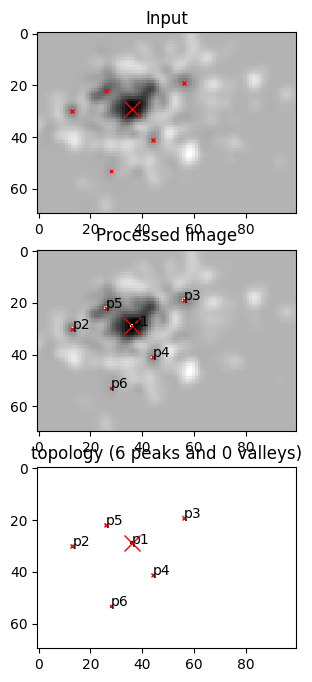

(<Axes: title={'center': 'Input'}>,
 <Axes: title={'center': 'Processed image'}>,
 <Axes: title={'center': 'topology (6 peaks and 0 valleys)'}>)

In [137]:
from findpeaks import findpeaks

fp = findpeaks(method='topology', whitelist=['peak'], limit=10)
peaks = fp.fit(gaussian_filter(Z, sigma=2)).get('persistence')

fp.plot()

The package finds 6 peaks in the price per square meter. We can plot these peaks on the map of Prague to see where the priciest locations are.

In [129]:
peaks['lon'] = peaks['x'].map(lambda x: (x_space[x] + x_space[x+1]) / 2)
peaks['lat'] = peaks['y'].map(lambda x: (y_space[x] + y_space[x+1]) / 2)

peaks

,x,y,birth_level,death_level,score,peak,valley,lon,lat
0,36,29,255.040969,0.000000,255.040969,True,False,14.428020,50.076835
1,13,30,126.063120,79.071303,46.991817,True,False,14.334927,50.073803
2,56,19,127.099444,85.016808,42.082636,True,False,14.508970,50.107161
3,44,41,111.044807,71.097730,39.947077,True,False,14.460400,50.040445
4,26,22,164.047703,132.055574,31.992129,True,False,14.387545,50.098063
5,28,53,88.026383,75.031489,12.994895,True,False,14.395640,50.004054


In [131]:
import haversine

peak_distances = haversine.haversine_vector(
    peaks[['lat', 'lon']].to_numpy(),
    real_estate[['locality_gps_lat', 'locality_gps_lon']].to_numpy(),
    unit='m',
    comb=True
)

real_estate['distance_to_closest_peak'] = peak_distances.min(axis=1)

In [132]:
mu.get_map_scale(
    real_estate[real_estate['distance_to_closest_peak'] < 10000],
    color_attribute='distance_to_closest_peak',
    title='Distance to the closest peak in the price per sqm map',
    scale_label='Distance (m)',
).savefig(
    'img/comb/08_distance_to_peak.png', 
    bbox_inches='tight'
)

|![Priciest locations in Prague](./img/comb/08_distance_to_peak.png)|
|:--:|
|*Map of the distance to the nearest peak in the price per square meter map.*|

In [133]:
get_correlation_matrix(real_estate)['distance_to_closest_peak'].sort_values(ascending=False, key=lambda x: x.abs()).head(20)

distance_to_closest_peak       1.000000
nearest_tram                   0.695468
nearest_abnb                   0.597998
nearest_atm                    0.560613
nearest_metro                  0.550494
school_count_1km              -0.550390
nearest_motorway              -0.546210
abnb_count_1km                -0.458791
park_count_1km                -0.445790
nearest_primary                0.439780
nearest_school                 0.412662
locality_quarter_id            0.347559
locality_gps_lon               0.316328
locality_ward_id              -0.246572
atm_count_1km                 -0.246165
price_summary_czk             -0.243915
price_per_sqm                 -0.227122
energy_efficiency_rating_cb   -0.194637
nearest_park                   0.187014
usable_area                   -0.165917
Name: distance_to_closest_peak, dtype: float64

It indeed seems that a lot of the features we've added to the dataset are just proxies for the location of the listings. The priciest locations are in the city center, while the less expensive locations are in the suburbs.

## Conclusion

In this notebook, we've explored the rental listings from the Sreality API and enriched them with the data from the OpenStreetMap and Airbnb datasets.

We've found out that the price of the listings is quite dependent on the location of the listing - the city center is the most expensive area, while the suburbs are the cheapest.

By analyzing the complete correlation matrix, we've found out that the price of the listings is quite dependent on all the features we've added to the dataset. However, we've also found out that the correlation among those features is also high - this might hint at the fact that the features are not independent and might all be proxies for the same underlying (set of?) feature(s).